# e-commerce data Cohort 분석

#### 1.0 데이터 읽기 및 전처리

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
folder = 'C:/Users/su/OneDrive - 청주대학교 (1)/datasets/before/2023'
file_name = '[2023_07_26]E_Commerce_Data'
e_data = 'data.csv'

In [3]:
# fifa_data_one = pd.read_csv(os.path.join(folder, file_name, fifa1))
encoding="unicode_escape"
encoding="ISO-8859-1"
e_data = pd.read_csv(os.path.join(folder, file_name, e_data), encoding=encoding)

In [5]:
e_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
e_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# type 변경
e_data['InvoiceDate'] = pd.to_datetime(e_data['InvoiceDate'])
print(e_data['InvoiceDate'])

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]


In [14]:
# 취소된 주문 제거(수량이 1이상인 것만 데이터 남김)
e_data = e_data[e_data['Quantity'] > 0]
e_data.shape

(531285, 9)

In [15]:
# 주문고객번호가 있는 것만 남김
e_data = e_data.dropna(axis=0, subset=['CustomerID'])
e_data.shape

(397924, 9)

In [16]:
# Sales column 추가
e_data['Sales'] = e_data['Quantity'] * e_data['UnitPrice']
e_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_period,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


#### 2.0 Cohort 분석

##### 2.1 필요 column 생성 및 집계

In [17]:
# 재주문을 확인하기 위한 orderperiod column 생성
cohorts = e_data
cohorts['order_period'] = cohorts.InvoiceDate.dt.strftime('%Y-%m')
cohorts.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_period,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


In [18]:
# cohort 그룹 생성. 사용자 넘버인 CustomerID를 그룹으로, 첫 구매일자를 기준.
cohorts = cohorts.set_index('CustomerID')
cohorts['cohort_group'] = cohorts.groupby(level=0)['InvoiceDate'].min().dt.strftime('%Y-%m')
cohorts = cohorts.reset_index()
cohorts.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_period,Sales,cohort_group
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,2010-12,15.30,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12
2,17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,2010-12,22.00,2010-12
3,17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12
4,17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,20.34,2010-12


In [19]:
# 제대로 그룹이 생성되었는지 확인
cohorts[cohorts.CustomerID == 12347]

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,order_period,Sales,cohort_group
10516,12347.0,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,2010-12,25.20,2010-12
10517,12347.0,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,2010-12,17.00,2010-12
10518,12347.0,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,2010-12,39.00,2010-12
10519,12347.0,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,2010-12,23.40,2010-12
10520,12347.0,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,Iceland,2010-12,15.00,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
394473,12347.0,581180,20719,WOODLAND CHARLOTTE BAG,10,2011-12-07 15:52:00,0.85,Iceland,2011-12,8.50,2010-12
394474,12347.0,581180,21265,PINK GOOSE FEATHER TREE 60CM,12,2011-12-07 15:52:00,1.95,Iceland,2011-12,23.40,2010-12
394475,12347.0,581180,23271,CHRISTMAS TABLE SILVER CANDLE SPIKE,16,2011-12-07 15:52:00,0.83,Iceland,2011-12,13.28,2010-12
394476,12347.0,581180,23506,MINI PLAYING CARDS SPACEBOY,20,2011-12-07 15:52:00,0.42,Iceland,2011-12,8.40,2010-12


In [20]:
# 데이터 집계. cohort 그룹당, 주문일자(월별) 당. 고객 수, 물품 구매 수량, 물품 판매 금액.
cohorts_anal = cohorts.groupby(['cohort_group', 'order_period']).agg({
    'CustomerID' : pd.Series.nunique,
    'Quantity' : sum,
    'Sales' : sum
})
cohorts_anal.rename(columns={'CustomerID':'Customers'}, inplace=True)
cohorts_anal.sort_values(by='cohort_group').head(15)

Customers  Quantity       Sales
cohort_group order_period                                 
2010-12      2010-12             885    312280  572713.890
             2011-12             235    110629  185803.130
             2011-11             445    295675  513803.590
             2011-10             331    255634  456080.610
             2011-09             350    250114  472813.640
             2011-07             309    177188  310783.920
             2011-08             313    207217  331749.220
             2011-05             352    178599  336627.500
             2011-04             321    131378  204407.660
             2011-03             340    177580  303119.390
             2011-02             286    136860  233845.370
             2011-01             324    158708  276237.690
             2011-06             321    178645  314162.610
2011-01      2011-09             125     43888   72023.651
             2011-12              49     13650   26464.820

In [21]:
# 첫 구매일자 이후 걸린 기간을 체크하기 위한 cohort period column 생성.
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts_anal = cohorts_anal.groupby(level=0, group_keys=False).apply(cohort_period)
cohorts_anal.head(15)

Customers  Quantity      Sales  cohort_period
cohort_group order_period                                               
2010-12      2010-12             885    312280  572713.89              1
             2011-01             324    158708  276237.69              2
             2011-02             286    136860  233845.37              3
             2011-03             340    177580  303119.39              4
             2011-04             321    131378  204407.66              5
             2011-05             352    178599  336627.50              6
             2011-06             321    178645  314162.61              7
             2011-07             309    177188  310783.92              8
             2011-08             313    207217  331749.22              9
             2011-09             350    250114  472813.64             10
             2011-10             331    255634  456080.61             11
             2011-11             445    295675  513803.59             12
             2011-12             235    110629  185803.13             13
2011-01      2011-01             417    190439  293207.35              1
             2011-02              92     29573   55149.91              2

In [22]:
# Retention 결과를 (%) 비율로 나타내기 위한 cohort 그룹 별, 첫 구매일에 따른 고객 수
cohorts_anal.reset_index(inplace=True)
cohorts_anal.set_index(['cohort_group', 'cohort_period'], inplace=True)

cohort_group_size = cohorts_anal['Customers'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2010-12    885
2011-01    417
2011-02    380
2011-03    452
2011-04    300
Name: Customers, dtype: int64

In [23]:
# Retention 결과 백분율.
user_retention = cohorts_anal['Customers'].unstack(0).div(cohort_group_size, axis=1)
user_retention.head(10)

cohort_group,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cohort_period,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.366102,0.220624,0.186842,0.150442,0.213333,0.190141,0.173554,0.180851,0.207101,0.234114,0.240223,0.111111,NaN
3,0.323164,0.266187,0.186842,0.252212,0.203333,0.172535,0.157025,0.207447,0.248521,0.301003,0.114525,NaN,NaN
4,0.384181,0.230216,0.284211,0.199115,0.210000,0.172535,0.264463,0.223404,0.242604,0.113712,NaN,NaN,NaN
5,0.362712,0.321343,0.271053,0.223451,0.196667,0.207746,0.231405,0.271277,0.124260,NaN,NaN,NaN,NaN
6,0.397740,0.287770,0.247368,0.168142,0.226667,0.232394,0.334711,0.111702,NaN,NaN,NaN,NaN,NaN
7,0.362712,0.247002,0.252632,0.267699,0.216667,0.264085,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
8,0.349153,0.242206,0.278947,0.230088,0.260000,0.095070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.353672,0.299760,0.247368,0.278761,0.073333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 2.2 데이터 시각화(히트맵)

<AxesSubplot:title={'center':'Retention %'}, xlabel='cohort_period', ylabel='cohort_group'>

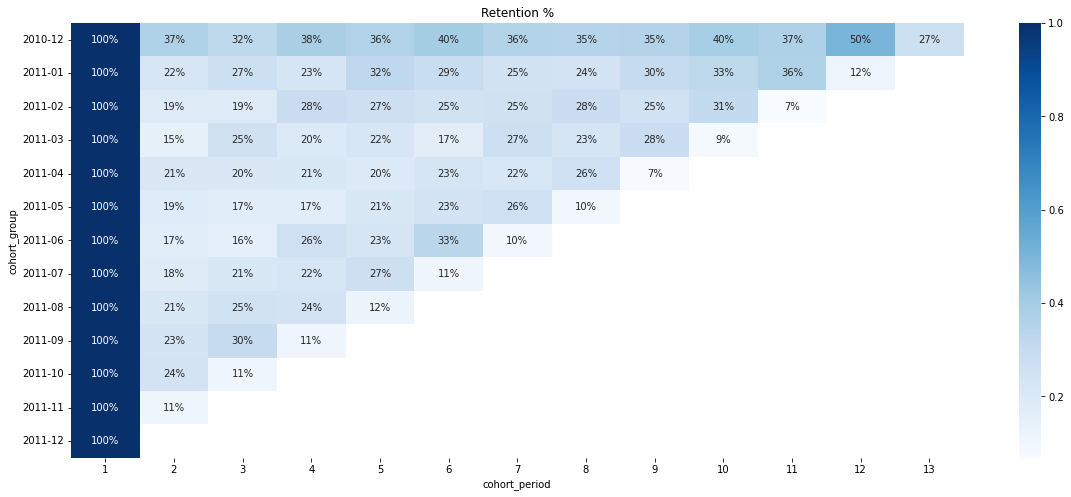

In [24]:
# 고객의 retention 백분율
plt.figure(figsize=(20, 8))
plt.title('Retention %')
sns.heatmap(
    user_retention.T,
    mask=user_retention.T.isnull(),
    annot=True,
    fmt='.0%',
    cmap='Blues',
    )

2010-12를 기준으로 32% ~ 50%가량의 재구매 고객이 있음을 확인할 수 있습니다.

<AxesSubplot:title={'center':'Retention & Sales($)'}, xlabel='cohort_period', ylabel='cohort_group'>

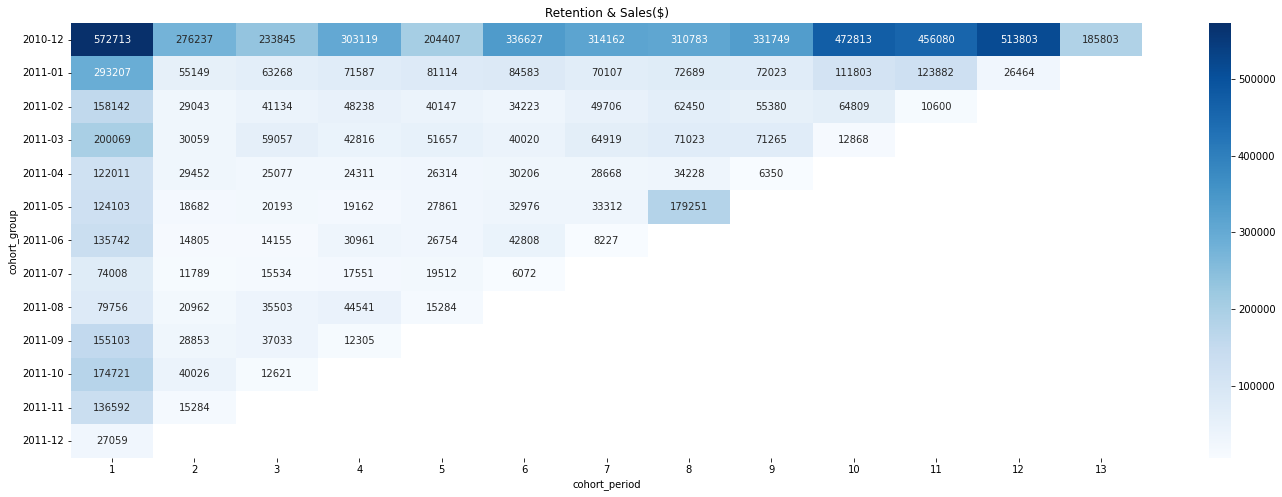

In [25]:
# cohort 그룹 별 구매한 금액 및 retention 확인
plt.figure(figsize=(24, 8))
plt.title('Retention & Sales($)')
sns.heatmap(
    cohorts_anal['Sales'].unstack(0).T.fillna(0).astype('int'),
    mask=user_retention.T.isnull(),
     annot=True,
     fmt= '0',
     cmap='Blues',
     )

2010-12인 그룹의 첫 구매 금액이 가장 많았고, 2011-07, 2011-08 그룹에서 고객의 유입이 적었거나 고객의 구매가 적은 것으로 확인됩니다.  
최근 구매 중 2010-12 그룹이 가장 많이 구매하였으며, 그 다음 2011-05 그룹의 구매 금액이 많았습니다. 제일 저조한 그룹은 2011-04 그룹이 제일 구매 금액이 적음을 보입니다.